In [55]:
''' The aim of this project is to predict Autism Spectrum Disorder (ASD) in adults when some behavioural
    features and personal attributes of some individuals are known. The data was obtained from kaggle website. 
    The data was cleaned, then explored and a classification model was built to predict ASD'''

__author__ = 'Sakiru Badmos (PhD)'
__email__ = 'babs4sure86@gmail.com'

# Can Autism Spectrum Disorder (ASD) in adult be predicted given some behavioral and demographic features?

## Introduction 

The growing number of ASD cases globally necesitates easy and effective screening procedure. A quick and efficient prediction of ASD is necessary to check whether formal clinical diagnosis is reguired for adults showing some signs of ASD.<br /> Early prediction of the possibility of ASD in adults will significantly improve behavior, as appropriate support could be provided.<br />  
In this project, I explored Autism data obtained from Kaggle website to predict ASD in adults given some behavioural (AQ-10-Adult) and individual characteristics features.


In [1]:
#Import the required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [115]:
#Define helper functions
def load_data(file):
    '''loads csv file into a pandas dataframe'''
    df= pd.read_csv(file, na_values = None)
    df.replace('?', np.nan, inplace=True)
    return df

def rename_col(df, rename_dict):
    df.rename(rename_dict, axis = 1, inplace= True)
    
def group_col(df):
    global numerical_var, cat_num_var, cat_var
    numerical_var = [col for col in df.columns if df[col].dtype !='O' and 
                 col not in ['Class', 'Case_No'] and df[col].nunique() > 50]
    cat_num_var = [col for col in df.columns if df[col].dtype !='O' and 
                     col not in ['Class', 'Case_No']]
    cat_var = [col for col in df.columns if df[col].dtype =='O' and col not in ['Class', 'Case_No']]
    return numerical_var, cat_var, cat_num_var

def transform_binary(df, col):
    df[col] = df[col].str.lower()
    df[col] = df[col].map({'yes': 1, 'no': 0})
    
def plot_cat_feature(df, col):
    df[col].value_counts().sort_index().plot(kind= 'bar')
    plt.xlabel(col)
    plt.ylabel('Counts')

def plot_outcome(df, col):
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    df.loc[df['Class'] == 1, col].value_counts().sort_index().plot(kind= 'bar')
    plt.title('Positive Class')
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1,2,2)
    df.loc[df['Class'] == 0, col].value_counts().sort_index().plot(kind= 'bar')
    plt.title('Negative Class')
    plt.xlabel(col)
    plt.ylabel('Counts')
    
def plot_outcome_fraction(df, col):
    positive= df.loc[df['Class'] == 1, col].value_counts().sort_index()
    negative= df.loc[df['Class'] == 0, col].value_counts().sort_index()
    pos_fraction= positive/(positive+negative)
    neg_fraction= negative/(positive+negative)
    plt.figure(figsize= (14, 6))
    plt.subplot(1,2,1)
    pos_fraction.plot(kind= 'bar')
    plt.title('Positive Class')
    plt.xlabel(col.capitalize())
    plt.ylabel('Fraction of class')
    plt.subplot(1,2,2)
    neg_fraction.plot(kind= 'bar')
    plt.title('Negative Class')
    plt.xlabel(col.capitalize())
    plt.ylabel('Fraction of class')

def check_null(df):
    return df.isnull().sum()/len(df)
def fill_na(df, col):
    df[col]= df[col].fillna('missing')

def check_duplicates(df,subset= None):
    df= shuffle(df).reset_index()
    return df.duplicated(subset= subset).sum()
    
def encode_feature(df):
    return pd.get_dummies(df, drop_first= True)

def get_features(df, target):
    return df.drop(target, axis='columns')

def get_target(df, target):
    return df[target]

def plot_corr(df):
    '''plot correlation between features and target'''
    plt.figure(figsize= (15,10))
    sns.heatmap(df.corr('spearman'), annot= True, linewidths= 0.15)
    plt.savefig('corrplot_adult.png')
    plt.show()

def model_trainer(model, X_train, y_train):
    model.fit(X_train, y_train)
    
def print_test_score(model, X_test, y_test, test_acc):
    acc = model.score(X_test, y_test)
    test_acc[model] = acc
    print('\nModel:\n', model)
    print('Test Accuracy:\n', acc)


def print_train_summary(model, train_acc):
    print('\nModel:\n', model)
    print('Training Accuracy:\n', train_acc[model])
    
def print_gs_summary(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    
def get_model_score(X_test, y_test, model= None):
    '''calculates accuracy and f1 scores of the model during model evaluation'''
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    
    print('Accuracy is : {:.2g}'.format(accuracy))
    print('Precision is : {:.2g}'.format(precision))
    print('Recall is : {:.2g}'.format(recall))
    f1 = 2*precision*recall/(precision+recall)
    f1_weighted = f1_score(y_test, y_pred, average = 'weighted')*100
    
    print('f1 score (weighted) is : {:.2g}'.format(f1_weighted))
    print('f1 score (calculated) is : {:.2g}'.format(f1))
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
def get_cross_val_score_(X_train, y_train, model = None, model_name= None, option=None):
    '''calculates mean accuracy and f1 scores from cross validation'''
    avg_accuracy= np.mean(cross_val_score(model, X_train, y_train, scoring= 'accuracy', cv=cv)) *100
    print("The mean accuracy for cross validation on {} set is {:2g}".format(option,avg_accuracy))
    
    avg_precision= np.mean(cross_val_score(model, X_train, y_train, scoring= 'precision', cv=cv)) *100
    print("The mean precision for cross validation on {} set is {:2g}".format(option,avg_precision))
    
    avg_recall= np.mean(cross_val_score(model, X_train, y_train, scoring= 'recall', cv=cv)) *100
    print("The mean recall for cross validation on {} set is {:2g}".format(option,avg_recall))
    
    avg_f1_weighted= np.mean(cross_val_score(model, X_train, y_train, scoring= 'f1_weighted', cv=cv))*100
    print("The mean F1-score (weighted) for cross validation on {} set is {:2g}".format(option, avg_f1_weighted))
    
    avg_f1_micro= np.mean(cross_val_score(model, X_train, y_train, scoring= 'f1_micro', cv=cv))*100
    print("The mean F1-score (micro) for cross validation on {} set is {:2g}".format(option, avg_f1_micro))
    
    avg_f1_macro= np.mean(cross_val_score(model, X_train, y_train, scoring= 'f1_macro', cv=cv))*100
    print("The mean F1-score (macro) for cross validation on {} set is {:2g}".format(option, avg_f1_macro))
    
    avg_f1= (2 * avg_precision * avg_recall)/(avg_precision + avg_recall)
    print("The mean F1-score (calculated) for cross validation on {} set is {:2g}".format(option,avg_f1))

    
def plot_feature_importance(model):
    fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize=(10,8))
    model_1_FI = pd.Series(model[0].best_estimator_.feature_importances_, index=X_train.columns).head(15).sort_values()
    model_2_FI = pd.Series(model[1].best_estimator_.feature_importances_, index=X_train.columns).head(15).sort_values()
    model_3_FI = pd.Series(model[2].best_estimator_.feature_importances_, index=X_train.columns).head(15).sort_values()
    model_4_FI = pd.Series(model[3].best_estimator_.feature_importances_, index=X_train.columns).head(15).sort_values()
    ax1.barh(model_1_FI.index, model_1_FI.values, color='red')
    ax2.barh(model_2_FI.index, model_2_FI.values, color='blue')
    ax3.barh(model_3_FI.index, model_3_FI.values, color='green')
    ax4.barh(model_4_FI.index, model_4_FI.values, color='purple')
    ax1.set_title(' Decision Tree Feature Importances')
    ax1.set_xlabel('Importances')
    ax1.set_ylabel('Features')
    ax2.set_title('Random Forest Feature Importances')
    ax2.set_xlabel('Importances')
    ax2.set_ylabel('Features')
    ax3.set_title('Gradient Boosting Feature Importances')
    ax3.set_xlabel('Importances')
    ax3.set_ylabel('Features')
    ax4.set_title('Adaboost Feature Importances')
    ax4.set_xlabel('Importances')
    ax4.set_ylabel('Features')
    plt.tight_layout()
    plt.savefig('Adult_FI.png')
    
def print_confusion_matrix(model, y_test, model_list):
    
    y_pred_1 = model[0].best_estimator_.predict(X_test)
    y_pred_2 = model[1].best_estimator_.predict(X_test)
    y_pred_3 = model[2].best_estimator_.predict(X_test)
    y_pred_4 = model[3].best_estimator_.predict(X_test)
    y_pred_5 = model[4].best_estimator_.predict(X_test)
    cnf_matrix_1 = metrics.confusion_matrix(y_test, y_pred_1)
    cnf_matrix_2 = metrics.confusion_matrix(y_test, y_pred_2)
    cnf_matrix_3 = metrics.confusion_matrix(y_test, y_pred_3)
    cnf_matrix_4 = metrics.confusion_matrix(y_test, y_pred_4)
    cnf_matrix_5 = metrics.confusion_matrix(y_test, y_pred_5)
    class_names=[0,1] 
    #fig, ([ax1,ax2],[ax3,ax4],[ax5,ax6]) = plt.subplots(3,2, figsize=(10,8))
    fig = plt.figure(figsize=(14,8))
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix_1), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax1)
    sns.heatmap(pd.DataFrame(cnf_matrix_2), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax2)
    sns.heatmap(pd.DataFrame(cnf_matrix_3), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax3)
    sns.heatmap(pd.DataFrame(cnf_matrix_4), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax4)
    sns.heatmap(pd.DataFrame(cnf_matrix_5), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax5)
    #ax1.set_title('Naive Bayes CM')
    #ax2.set_title('Decision Tree CM')
    #ax3.set_title('Random Forest CM')
    #ax4.set_title('Gradient Boosting CM')
    #ax5.set_title('Adaboost CM')
    for i, ax in enumerate(fig.axes):
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title(model_list[i] + ' ' + 'CM')
        ax.xaxis.set_label_position('top')
   # fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    plt.tight_layout()
    
def plot_roc(model, X_test, y_test):
    '''Takes model, and testing data as arguments and plots the ROC curve '''
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [3]:
#load the data
autism_adult = load_data('Autism_Data.arff')
autism_adult.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,NaN,no,no,Egypt,no,2,'18 and more',NaN,NO


In [4]:
autism_adult.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

In [5]:
#rename columns
rename_dict = {'jundice': 'Had_jaundice', 'austim': 'ASD_History', 'contry_of_res': 'Country_of_res', 
               'relation': 'Test_taker_rel', 'Class/ASD': 'Class' }
rename_col(autism_adult, rename_dict)

In [6]:
autism_adult.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'Had_jaundice', 'ASD_History', 'Country_of_res',
       'used_app_before', 'result', 'age_desc', 'Test_taker_rel', 'Class'],
      dtype='object')

In [7]:
# cast age column 
autism_adult['age'] = autism_adult['age'].astype(float)

In [8]:
group_col(autism_adult)

([],
 ['gender',
  'ethnicity',
  'Had_jaundice',
  'ASD_History',
  'Country_of_res',
  'used_app_before',
  'age_desc',
  'Test_taker_rel'],
 ['A1_Score',
  'A2_Score',
  'A3_Score',
  'A4_Score',
  'A5_Score',
  'A6_Score',
  'A7_Score',
  'A8_Score',
  'A9_Score',
  'A10_Score',
  'age',
  'result'])

## Exploratory Data Analysis 

In [9]:
autism_adult.shape

(704, 21)

In [10]:
# Get some information about the data
autism_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
A1_Score           704 non-null int64
A2_Score           704 non-null int64
A3_Score           704 non-null int64
A4_Score           704 non-null int64
A5_Score           704 non-null int64
A6_Score           704 non-null int64
A7_Score           704 non-null int64
A8_Score           704 non-null int64
A9_Score           704 non-null int64
A10_Score          704 non-null int64
age                702 non-null float64
gender             704 non-null object
ethnicity          609 non-null object
Had_jaundice       704 non-null object
ASD_History        704 non-null object
Country_of_res     704 non-null object
used_app_before    704 non-null object
result             704 non-null int64
age_desc           704 non-null object
Test_taker_rel     609 non-null object
Class              704 non-null object
dtypes: float64(1), int64(11), object(9)
memory usage: 115.6+ KB


There seems to be some missing values. Lets check this!

In [11]:
# Check for missing values
check_null(autism_adult)

A1_Score           0.000000
A2_Score           0.000000
A3_Score           0.000000
A4_Score           0.000000
A5_Score           0.000000
A6_Score           0.000000
A7_Score           0.000000
A8_Score           0.000000
A9_Score           0.000000
A10_Score          0.000000
age                0.002841
gender             0.000000
ethnicity          0.134943
Had_jaundice       0.000000
ASD_History        0.000000
Country_of_res     0.000000
used_app_before    0.000000
result             0.000000
age_desc           0.000000
Test_taker_rel     0.134943
Class              0.000000
dtype: float64

Age, ethnicity and Test_taker_rel columns have some missing records

In [12]:
check_duplicates(autism_adult)

0

No duplicate found

## Data Cleaning

In [13]:
autism_adult.head(3)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,Had_jaundice,ASD_History,Country_of_res,used_app_before,result,age_desc,Test_taker_rel,Class
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,YES


In [14]:
# convert target values to lower case
autism_adult['Class'] = autism_adult['Class'].str.lower()

In [15]:
# Transform all columns with yes/no values to 1/0
column_to_transform = ['Had_jaundice', 'ASD_History', 'used_app_before', 'Class']
for col in column_to_transform:
    transform_binary(autism_adult, col)

In [16]:
autism_adult.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,Had_jaundice,ASD_History,Country_of_res,used_app_before,result,age_desc,Test_taker_rel,Class
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,0,0,'United States',0,6,'18 and more',Self,0
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,0,1,Brazil,0,5,'18 and more',Self,0
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,1,1,Spain,0,8,'18 and more',Parent,1
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,0,1,'United States',0,6,'18 and more',Self,0
4,1,0,0,0,0,0,0,1,0,0,...,f,NaN,0,0,Egypt,0,2,'18 and more',NaN,0


In [17]:
# fill missing values in ethnicity and Test_taker_rel columns with the word 'missing'
col_with_na = ['ethnicity', 'Test_taker_rel']
for col in col_with_na:
    fill_na(autism_adult, col)

In [18]:
check_null(autism_adult)

A1_Score           0.000000
A2_Score           0.000000
A3_Score           0.000000
A4_Score           0.000000
A5_Score           0.000000
A6_Score           0.000000
A7_Score           0.000000
A8_Score           0.000000
A9_Score           0.000000
A10_Score          0.000000
age                0.002841
gender             0.000000
ethnicity          0.000000
Had_jaundice       0.000000
ASD_History        0.000000
Country_of_res     0.000000
used_app_before    0.000000
result             0.000000
age_desc           0.000000
Test_taker_rel     0.000000
Class              0.000000
dtype: float64

Since age column has only two records missing, the rows containing the missing values will be dropped

In [19]:
# drop rows containing any NaN value. This will drop the two rows where age column having NaN values
autism_adult.dropna(how='any', inplace=True)

In [20]:
check_null(autism_adult)

A1_Score           0.0
A2_Score           0.0
A3_Score           0.0
A4_Score           0.0
A5_Score           0.0
A6_Score           0.0
A7_Score           0.0
A8_Score           0.0
A9_Score           0.0
A10_Score          0.0
age                0.0
gender             0.0
ethnicity          0.0
Had_jaundice       0.0
ASD_History        0.0
Country_of_res     0.0
used_app_before    0.0
result             0.0
age_desc           0.0
Test_taker_rel     0.0
Class              0.0
dtype: float64

The data is now clean ready for exploration and modelling

## Visualize features

**Plot categorical numerical features**

In [21]:
cat_num_var.remove('result')

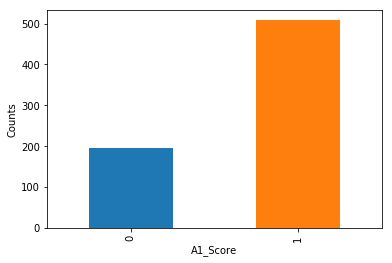

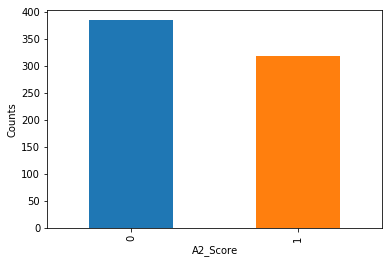

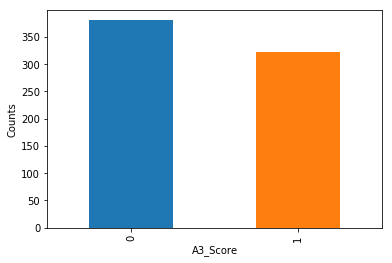

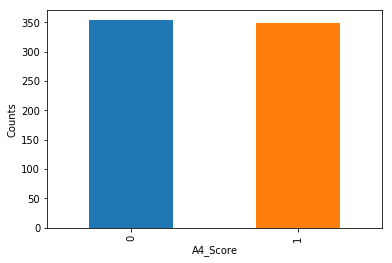

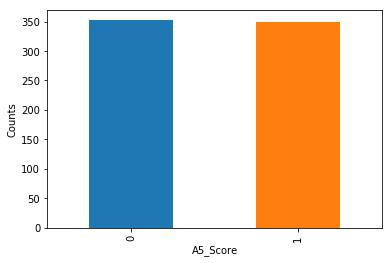

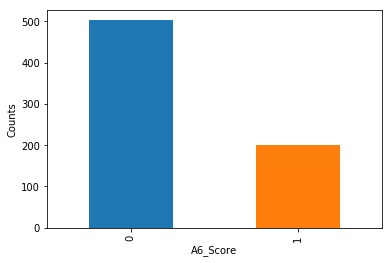

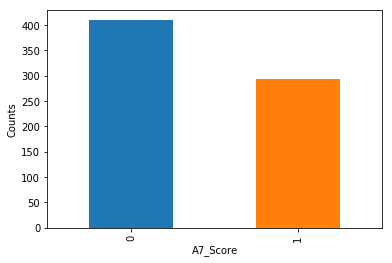

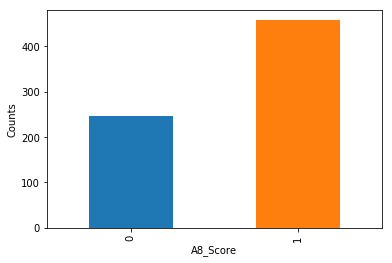

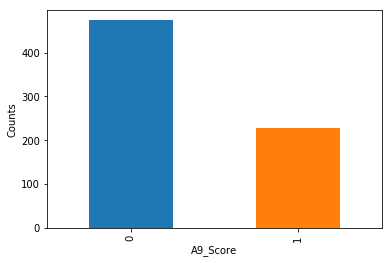

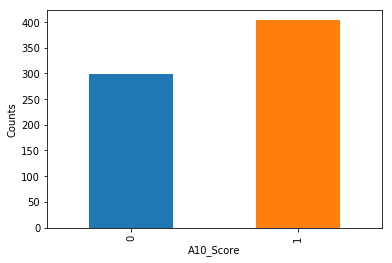

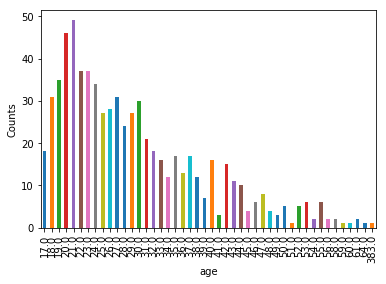

In [22]:
for col in cat_num_var:
    plot_cat_feature(autism_adult, col)
    plt.show()

Most of the A1-A10 columns have reasonable distributions of the labels. It looks like younger people (ages 20-30) participated than older people (31-64)

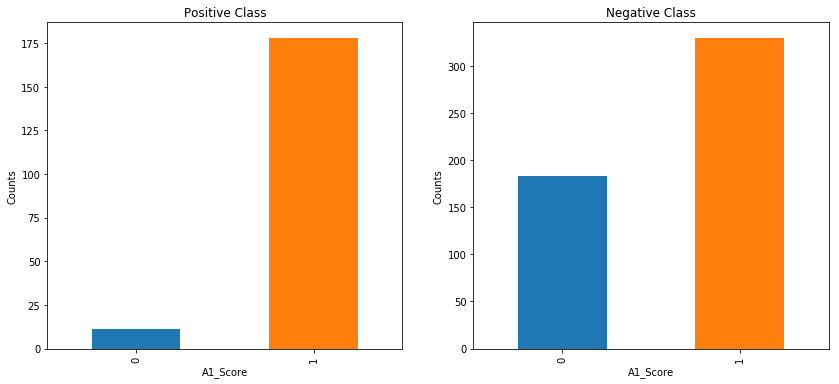

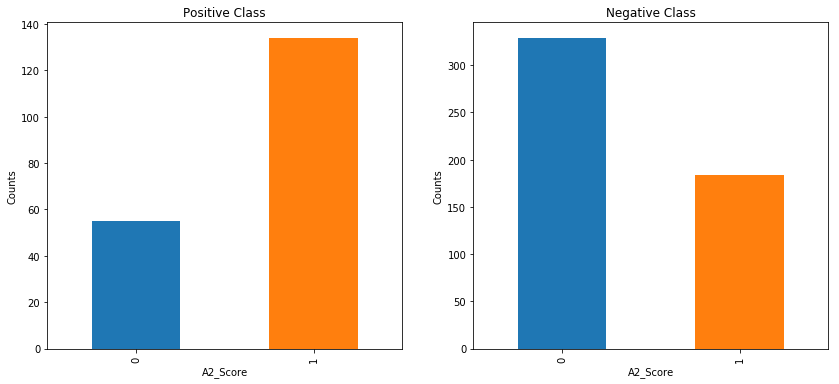

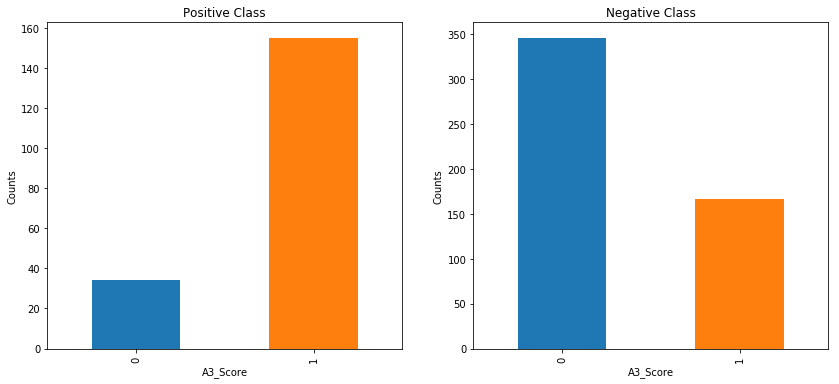

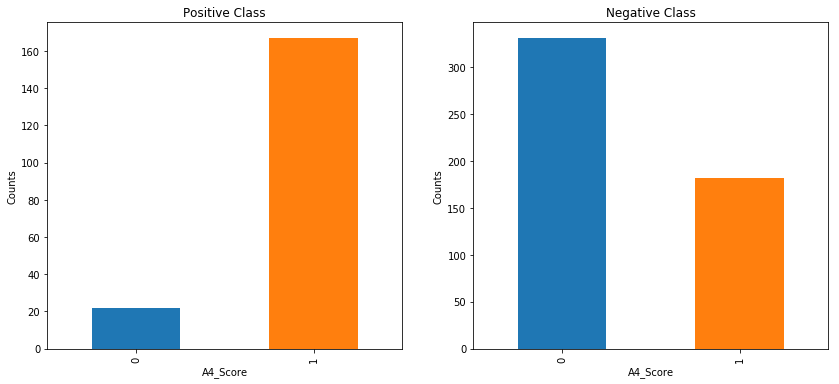

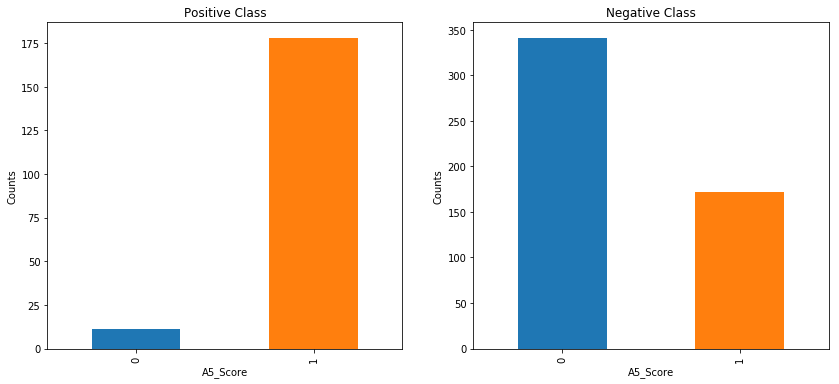

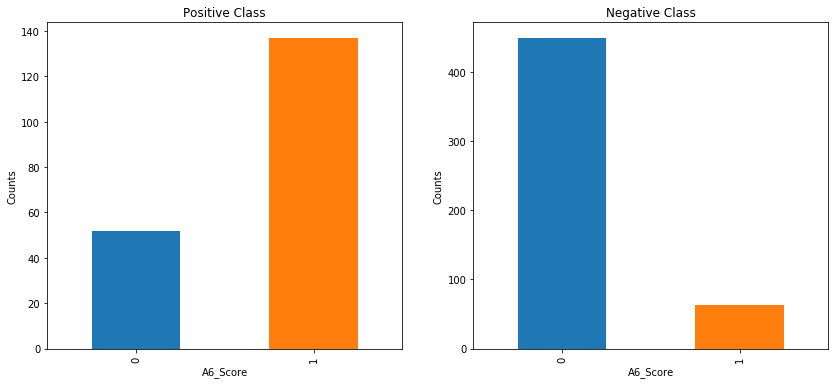

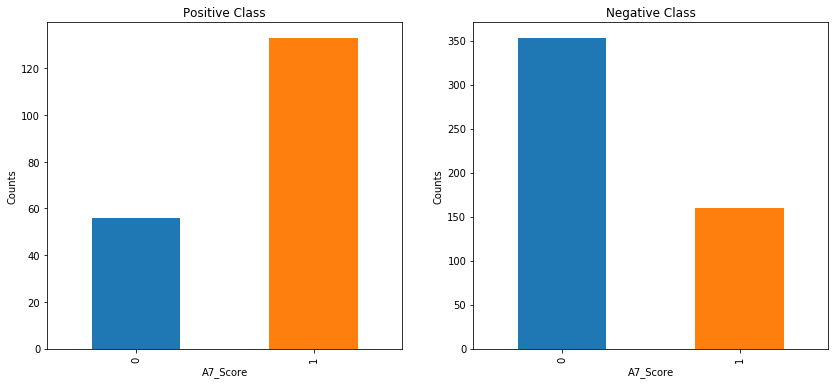

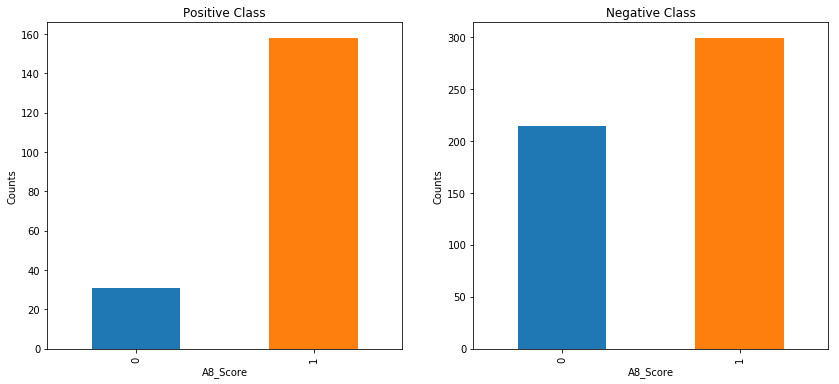

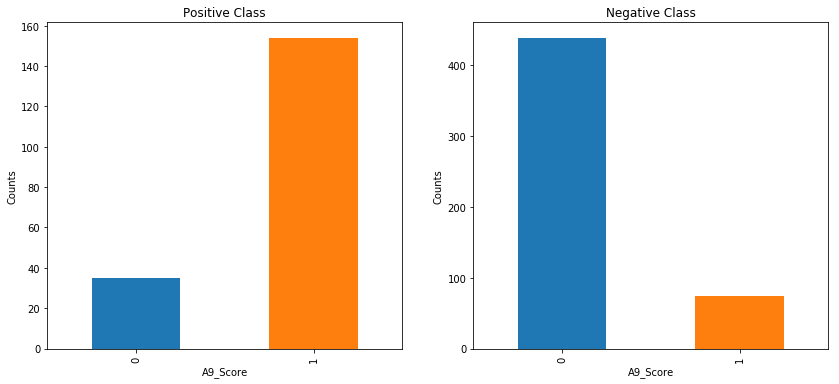

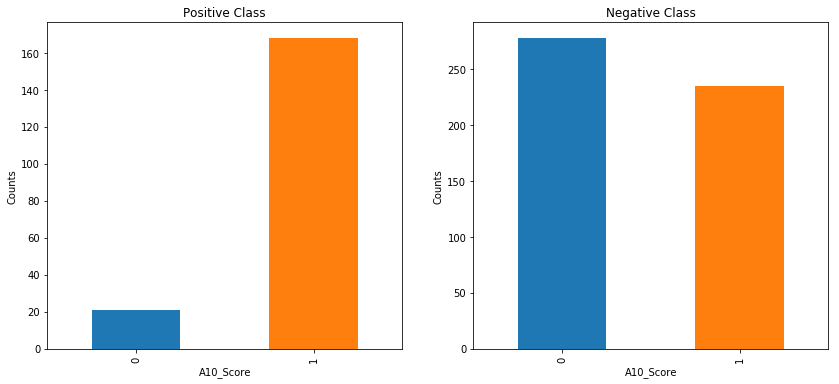

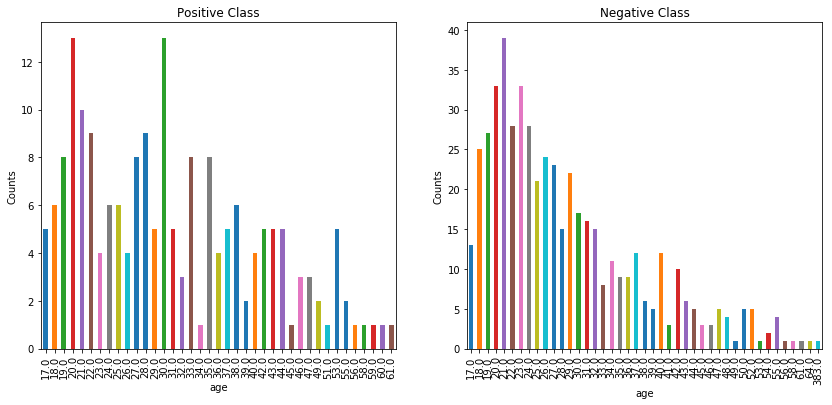

In [23]:
# These plots shows the distribution of the feature at each target label. 
# For example, how many people who had autism answered 'Yes' for A1_Score and how many people answered 'No'  
for col in cat_num_var:
    plot_outcome(autism_adult, col)
    plt.show()

Based on the distribution of the class labels, people that had autism in general answered yes for A1-A10 scores and people that answered no did not have autism. This shows that there is an association between the responses to these questions and autism.

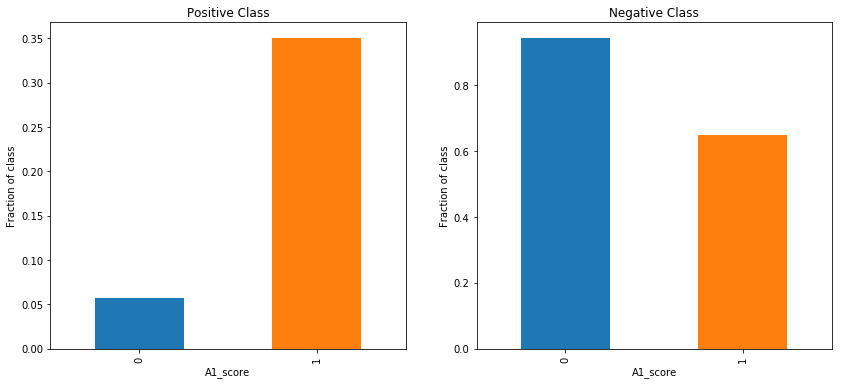

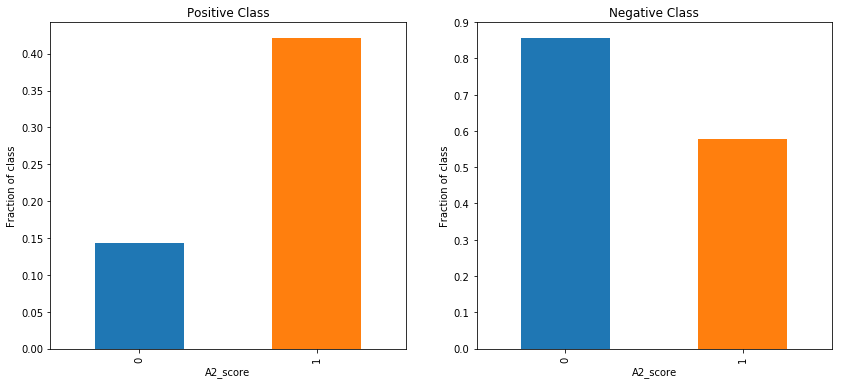

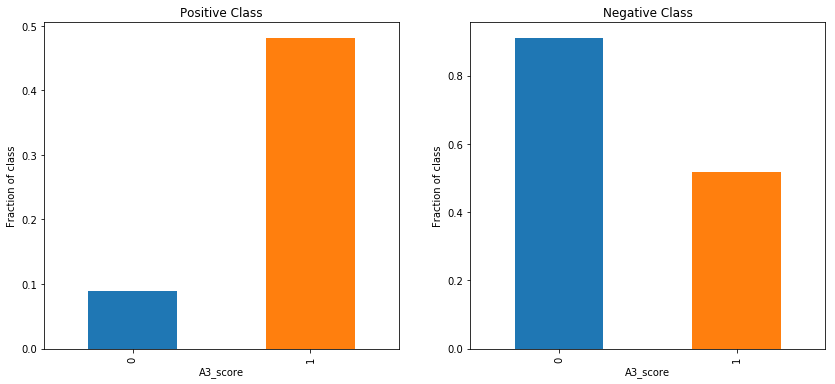

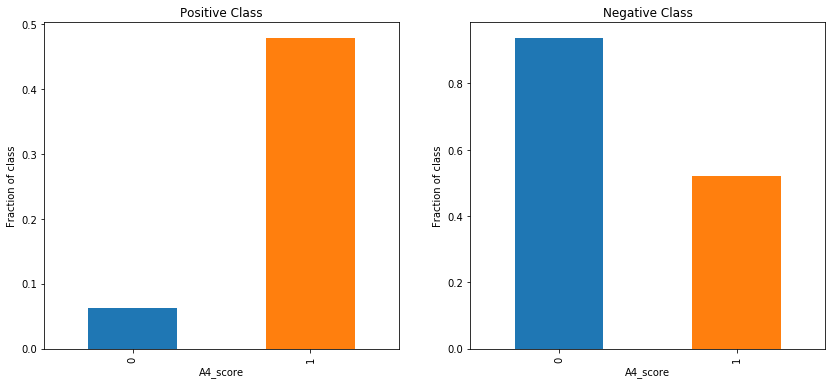

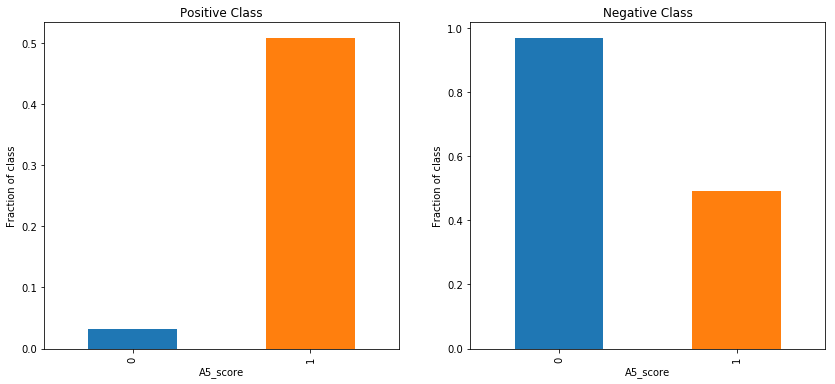

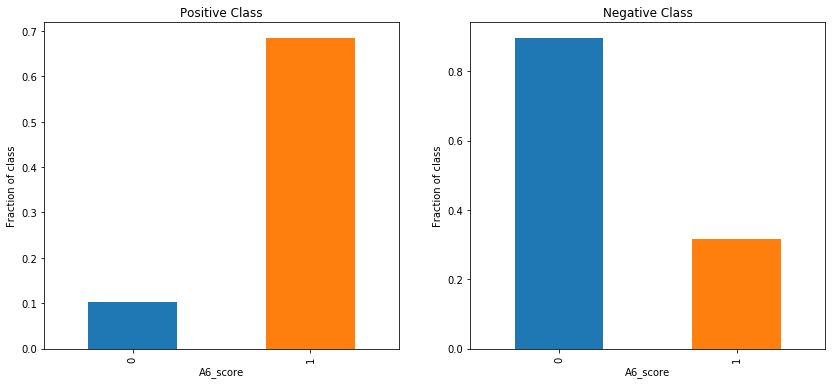

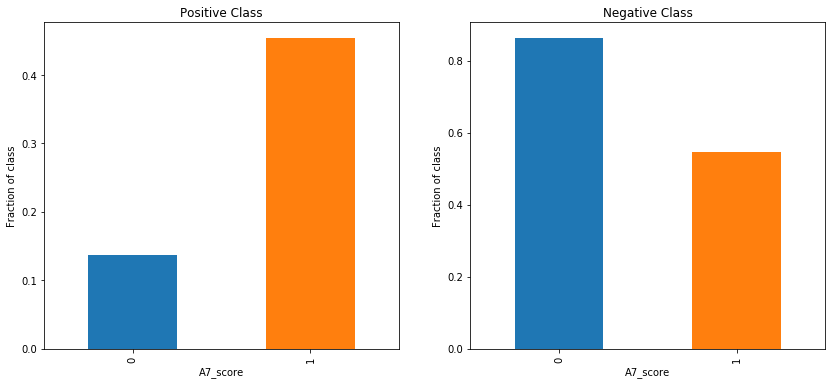

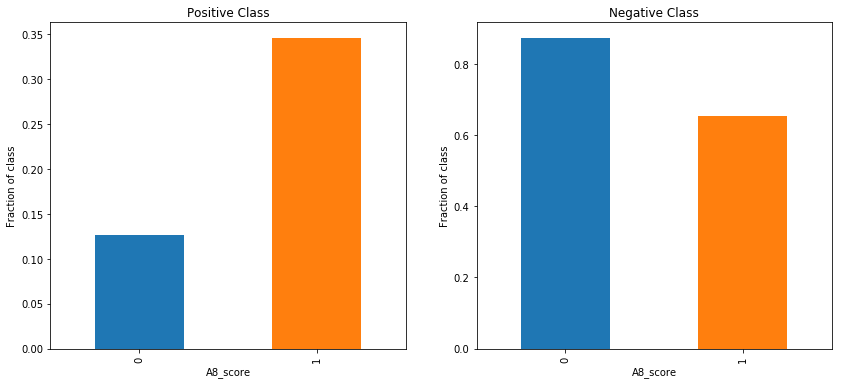

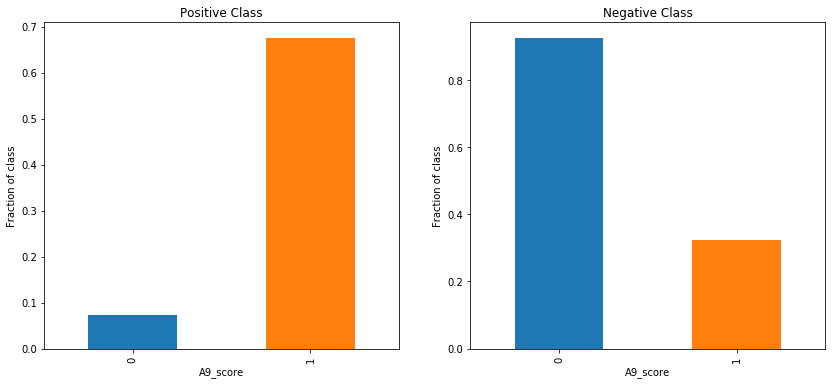

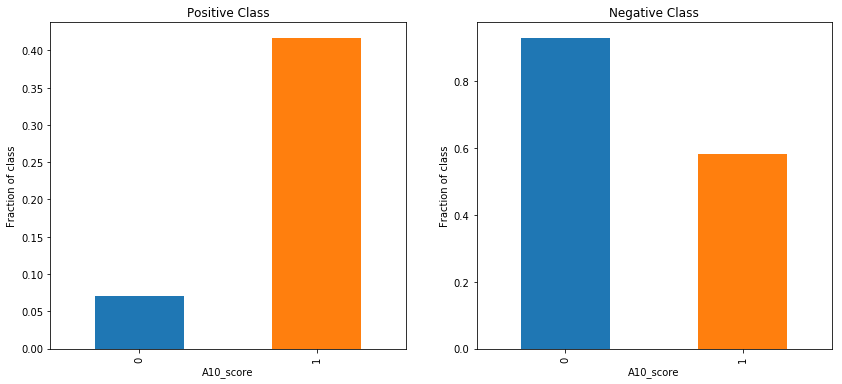

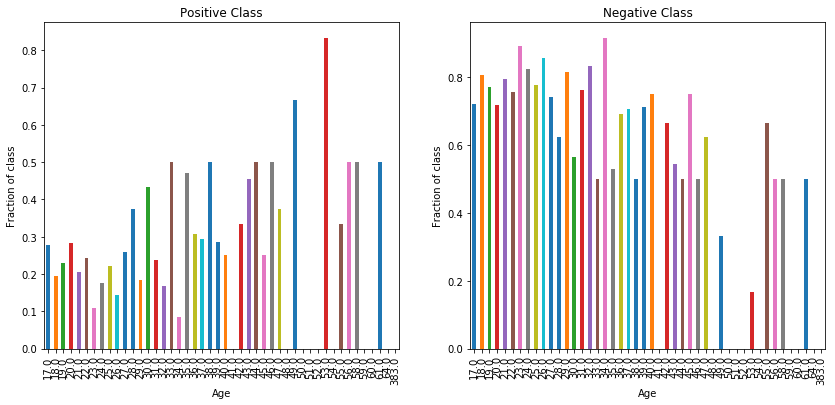

In [24]:
for col in cat_num_var:
    plot_outcome_fraction(autism_adult, col)
    plt.show()

In general, more people did not have autism in for each age category.

**Plot Categorical features**

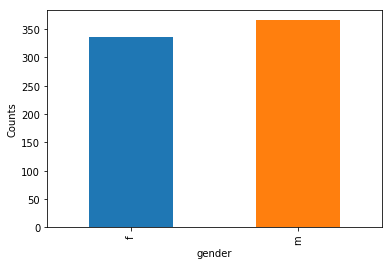

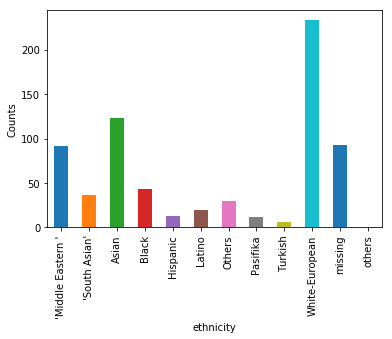

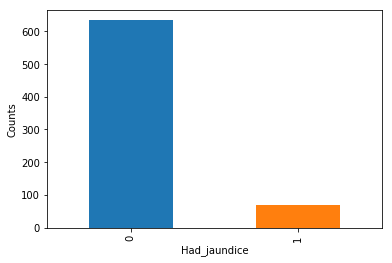

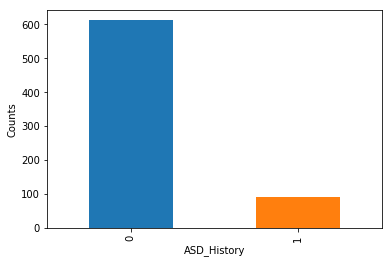

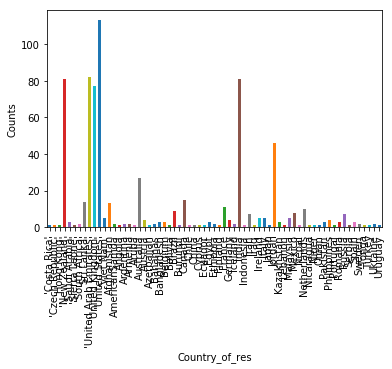

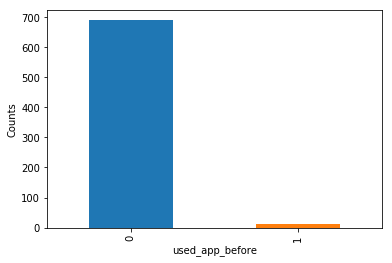

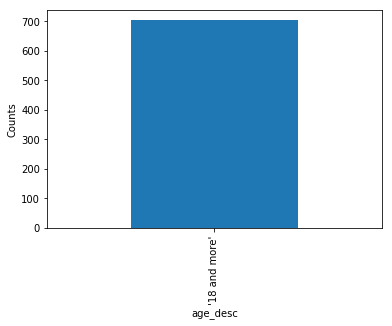

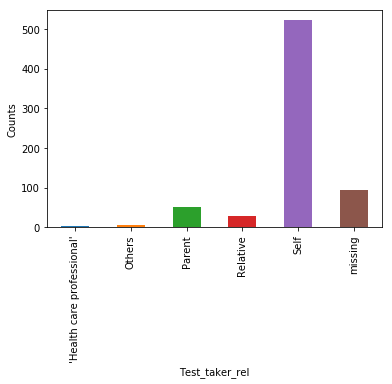

In [25]:
for col in cat_var:
    plot_cat_feature(autism_adult, col)
    plt.show()

For the categorical features, 
- there is roughly equal distribution of male and female categories. 
- White-European people participated the most
- More people had Jaundice when they were born
- People that participated are mostly from the US,UAE, New Zealand and UK.
- Most people that participated have not used the app before
- Most people participated in person

**The 'result' column needs to be dropped as it was used to determine the class. This is necessary to prevent overfitting and target leakage. The age_desc column is also not relevant for prediction as it contains just one unique value**

In [26]:
#save a copy of the data
autism_adult_copy = autism_adult

In [27]:
#drop 'result' and 'age_desc' columns
autism_adult.drop(['result', 'age_desc'], axis= 'columns', inplace=True)

In [28]:
autism_adult.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'Had_jaundice', 'ASD_History', 'Country_of_res',
       'used_app_before', 'Test_taker_rel', 'Class'],
      dtype='object')

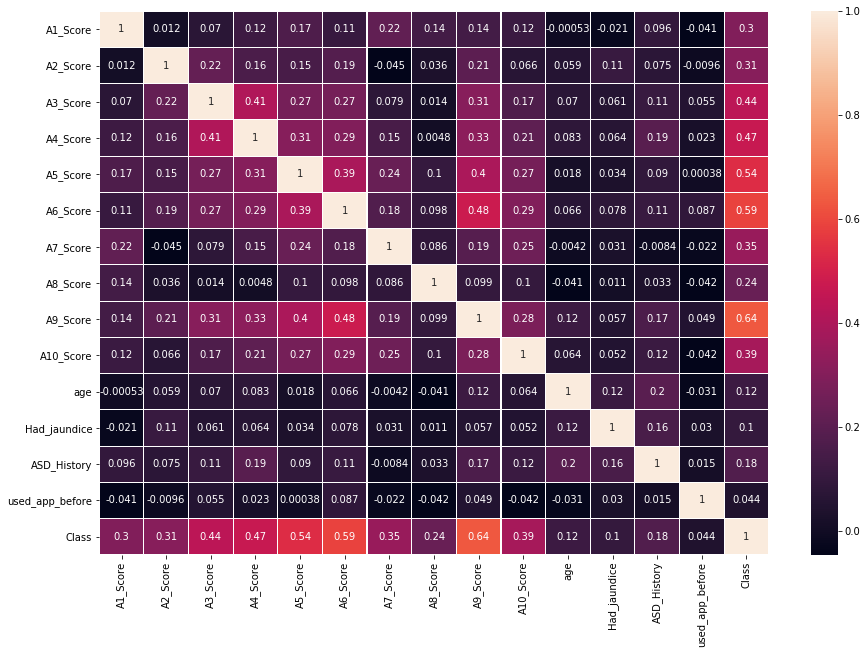

In [29]:
#plot correlation plot
plot_corr(autism_adult)

The correlation plot shows that A1 - A10 are strongly correlated with the target. The age of the child, whether the child developed jaundice and family history of autism are weakly correlated with the target. They might not be good predictors.

In [30]:
autism_adult = encode_feature(autism_adult)
autism_adult.shape

(702, 98)

## Build the model

When building machine learning (ML) models, It is important to have a reference baseline model. Logistic regression is a common baseline model used in ML space. However, because the dataset comprises of mostly categorical features, a linear model might not be a good baseline. As a result, a model that predicts the majority class is chosen. This model will have an accuracy that is equal to the fraction of the majority class in the target.

In [31]:
autism_adult_copy['Class'].value_counts(normalize=True)

0    0.730769
1    0.269231
Name: Class, dtype: float64

In [32]:
baseline_accuracy = (autism_adult_copy['Class'].value_counts(normalize=True).loc[0])*100

In [33]:
baseline_accuracy

73.07692307692307

The accuracy for the baseline model is 73%

In [34]:
# separate target and features
features = get_features(autism_adult, 'Class')
target = get_target(autism_adult, 'Class')

In [35]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((561, 97), (141, 97))

In [37]:
models = []

In [38]:
#Instantiate and build the models
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

gnb_model = GaussianNB()

DT_model = DecisionTreeClassifier(random_state=42)

svc= SVC(class_weight= 'balanced', probability= True, random_state= 42)
pipeline_svcb = Pipeline([('scaler', StandardScaler()),('svc', svc)])
rf_model = RandomForestClassifier(n_estimators= 8, max_depth=4, class_weight= 'balanced', random_state = 42)
gb_model= GradientBoostingClassifier(n_estimators= 6, max_depth= 3, random_state= 42)
adb = AdaBoostClassifier(n_estimators= 8, random_state= 42)

models.extend([gnb_model, DT_model, rf_model, gb_model, adb, pipeline_svcb]) 
for model in models:
    print(model)
    print('-'*70)
    model_trainer(model, X_train, y_train)
    get_model_score( X_test, y_test, model= model)
    print('*'*70)
    get_cross_val_score_(X_train, y_train, model=model, option='Training')
    print('*'*70)
    get_cross_val_score_(X_test, y_test, model=model, option = 'Test')
    print('-'*70)

GaussianNB(priors=None, var_smoothing=1e-09)
----------------------------------------------------------------------
Accuracy is : 37
Precision is : 35
Recall is : 94
f1 score (weighted) is : 25
f1 score (calculated) is : 51
[[ 5 86]
 [ 3 47]]
**********************************************************************
The mean accuracy for cross validation on Training set is 31.9099
The mean precision for cross validation on Training set is 25.9489
The mean recall for cross validation on Training set is 94.2593
The mean F1-score (weighted) for cross validation on Training set is 25.0701
The mean F1-score (micro) for cross validation on Training set is 31.9099
The mean F1-score (macro) for cross validation on Training set is 30.3098
The mean F1-score (calculated) for cross validation on Training set is 40.6948
**********************************************************************
The mean accuracy for cross validation on Test set is 71.0591
The mean precision for cross validation on Test set 

The mean accuracy for cross validation on Training set is 93.3925
The mean precision for cross validation on Training set is 84.0601
The mean recall for cross validation on Training set is 90.6085
The mean F1-score (weighted) for cross validation on Training set is 93.4821
The mean F1-score (micro) for cross validation on Training set is 93.3925
The mean F1-score (macro) for cross validation on Training set is 91.372
The mean F1-score (calculated) for cross validation on Training set is 87.2115
**********************************************************************
The mean accuracy for cross validation on Test set is 94.3596
The mean precision for cross validation on Test set is 94.1414
The mean recall for cross validation on Test set is 90
The mean F1-score (weighted) for cross validation on Test set is 94.2389
The mean F1-score (micro) for cross validation on Test set is 94.3596
The mean F1-score (macro) for cross validation on Test set is 93.59
The mean F1-score (calculated) for cro

## Hyperparameter tuning

In [39]:
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)
#--------------------------------------------------------------------------------

dt_classifier = DecisionTreeClassifier(max_depth= 15, class_weight= 'balanced', random_state = 42)
dt_max_depths = np.linspace(1, 32, 32, endpoint=True)
dt_min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
dt_min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
dt_max_features = list(range(1,X_train.shape[1]))
dt_param_grid = {'max_depth': range(2,15),
             'max_leaf_nodes': [None, 5, 10, 20, 40, 60, 80, 100]}
dt_grid_params = {'max_depth': dt_max_depths, 'min_sample_splits':dt_min_samples_splits}
gs_dt = GridSearchCV(dt_classifier, param_grid= dt_param_grid, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------


svc= SVC(class_weight= 'balanced', probability= True, random_state= 42)
pipeline_svc = Pipeline([('scaler', StandardScaler()),('svc', svc)])
#--------------------------------------------------------------------------------
rf_param_grid = {'max_depth': range(2,15),
             'n_estimators': [10,20,50, 100,200]}

rf_classifier= RandomForestClassifier(n_estimators= 10, class_weight= 'balanced', random_state = 42)
gs_rf_classifier = GridSearchCV(rf_classifier, param_grid=rf_param_grid, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------
gb1= GradientBoostingClassifier(random_state= 42)
param_grid_gbl = {'max_depth': range(2,6),
             'n_estimators': [10,20,50, 100,200]}

gs_gb = GridSearchCV(gb1, param_grid= param_grid_gbl, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------
adb = AdaBoostClassifier(random_state= 42)
param_grid_adb = {'learning_rate': [0.01, 0.1, 1],
             'n_estimators': [10,20,50, 100,200]}

gs_adb= GridSearchCV(adb, param_grid= param_grid_adb,scoring= 'f1_macro', cv=cv)
#--------------------------------------------------------------------------------
gnb = GaussianNB()

param_gnb= {'var_smoothing': np.logspace(-10,10,21)}

gs_gnb = GridSearchCV(gnb, param_grid= param_gnb, cv=cv)

In [59]:
# define a list to store the gridsearched models
gs_models = []

In [60]:
gs_models.extend([ gs_gnb, gs_dt, gs_rf_classifier, gs_gb, gs_adb])
for model in gs_models:
    model_trainer(model, X_train, y_train)
    print(model.best_estimator_)
    print('*'*70)
    get_cross_val_score_(X_train, y_train, model=model.best_estimator_, option='Training')
    print('*'*70)
    get_cross_val_score_(X_test, y_test, model=model.best_estimator_, option='Test')
    print('*'*70)

GaussianNB(priors=None, var_smoothing=0.001)
**********************************************************************
The mean accuracy for cross validation on Training set is 93.576
The mean precision for cross validation on Training set is 84.3253
The mean recall for cross validation on Training set is 91.4286
The mean F1-score (weighted) for cross validation on Training set is 93.6652
The mean F1-score (micro) for cross validation on Training set is 93.576
The mean F1-score (macro) for cross validation on Training set is 91.6438
The mean F1-score (calculated) for cross validation on Training set is 87.7334
**********************************************************************
The mean accuracy for cross validation on Test set is 91.5025
The mean precision for cross validation on Test set is 87.697
The mean recall for cross validation on Test set is 90
The mean F1-score (weighted) for cross validation on Test set is 91.5834
The mean F1-score (micro) for cross validation on Test set is 

IndexError: list index out of range

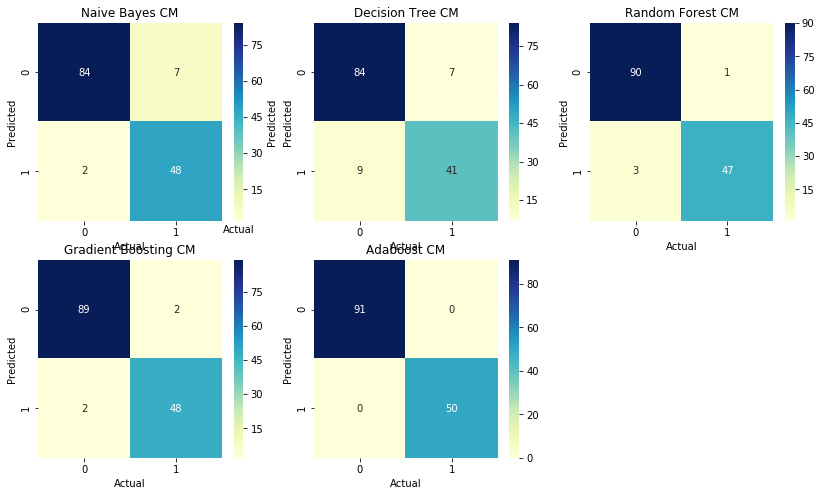

In [116]:
model_list = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Adaboost']
print_confusion_matrix(gs_models, y_test, model_list)

After tuning the parameters, Adaboost has the highest f1 score of 99% and accuracy of 97% and therefore declared as the best model for this dataset. 

The feature importances show that:
- A9 is the strongest predictor for decision tree model followed by A5
- A5 is the strongest predictor for random forest followed by A9
- A9 is the strongest predictor for gradient boosting followed by A6
- A7 is the strongest predictor for Adaboost followed by A4.
In general, responses to questions A1-A10 mostly determine whether the respondant has autism or not

In [43]:
model_list = [gs_dt, gs_rf_classifier, gs_gb, gs_adb]

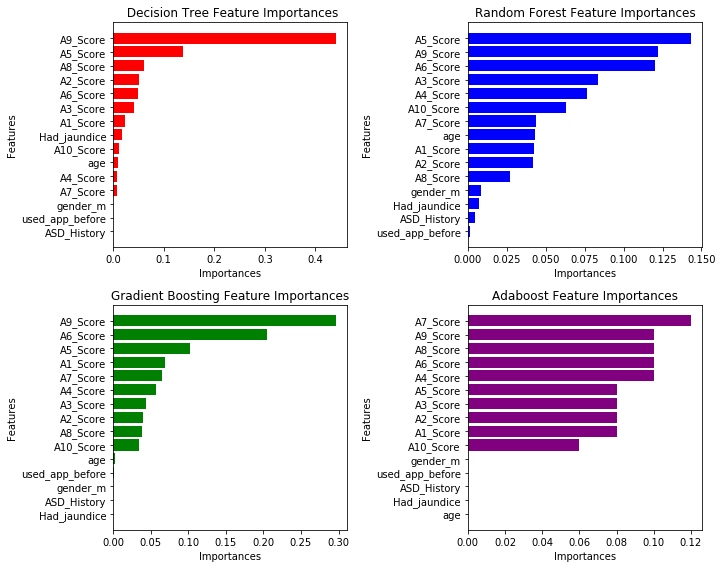

In [44]:
plot_feature_importance(model_list)

It looks like the models overfit. In order to solve this problem, the complexity of the model will be reduced by using only the A features (A1-A10) for modeling as they are more strongly correlated with the target.

**Modelling with A1-A10 features**

In [45]:
autism_adult_part = autism_adult_copy.iloc[:,0:10]

In [46]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(autism_adult_part, target, test_size =0.2, random_state=42)

In [47]:
models_p = []

In [48]:
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

gnb_model_p = GaussianNB()

DT_model_p = DecisionTreeClassifier(random_state=42)

svc_p= SVC(class_weight= 'balanced', probability= True, random_state= 42)
pipeline_svcb_p = Pipeline([('scaler', StandardScaler()),('svc', svc_p)])
rf_model_p = RandomForestClassifier(n_estimators= 8, max_depth=4, class_weight= 'balanced', random_state = 42)
gb_model_p= GradientBoostingClassifier(n_estimators= 6, max_depth= 3, random_state= 42)
adb_p = AdaBoostClassifier(n_estimators= 8, random_state= 42)

models_p.extend([gnb_model_p, DT_model_p, rf_model_p, gb_model_p, adb_p, pipeline_svcb_p]) 
for model in models_p:
    print(model)
    print('-'*70)
    model_trainer(model, X_train_p, y_train_p)
    get_model_score( X_test_p, y_test_p, model= model)
    print('*'*70)
    get_cross_val_score_(X_train_p, y_train_p, model=model, option='Training')
    print('*'*70)
    get_cross_val_score_(X_test_p, y_test_p, model=model, option = 'Test')
    print('-'*70)

GaussianNB(priors=None, var_smoothing=1e-09)
----------------------------------------------------------------------
Accuracy is : 97
Precision is : 98
Recall is : 94
f1 score (weighted) is : 97
f1 score (calculated) is : 96
[[90  1]
 [ 3 47]]
**********************************************************************
The mean accuracy for cross validation on Training set is 96.6038
The mean precision for cross validation on Training set is 93.0422
The mean recall for cross validation on Training set is 93.5185
The mean F1-score (weighted) for cross validation on Training set is 96.5944
The mean F1-score (micro) for cross validation on Training set is 96.6038
The mean F1-score (macro) for cross validation on Training set is 95.4186
The mean F1-score (calculated) for cross validation on Training set is 93.2797
**********************************************************************
The mean accuracy for cross validation on Test set is 92.1921
The mean precision for cross validation on Test set 

The mean accuracy for cross validation on Training set is 97.8634
The mean precision for cross validation on Training set is 93.357
The mean recall for cross validation on Training set is 98.5714
The mean F1-score (weighted) for cross validation on Training set is 97.8845
The mean F1-score (micro) for cross validation on Training set is 97.8634
The mean F1-score (macro) for cross validation on Training set is 97.1926
The mean F1-score (calculated) for cross validation on Training set is 95.8934
**********************************************************************
The mean accuracy for cross validation on Test set is 94.3103
The mean precision for cross validation on Test set is 89.5152
The mean recall for cross validation on Test set is 96
The mean F1-score (weighted) for cross validation on Test set is 94.3537
The mean F1-score (micro) for cross validation on Test set is 94.3103
The mean F1-score (macro) for cross validation on Test set is 93.9052
The mean F1-score (calculated) for c

**Hyperparameter tuning**

In [49]:
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)
#--------------------------------------------------------------------------------

dt_classifier_p = DecisionTreeClassifier(max_depth= 15, class_weight= 'balanced', random_state = 42)
dt_max_depths = np.linspace(1, 32, 32, endpoint=True)
dt_min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
dt_min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
dt_max_features = list(range(1,X_train.shape[1]))
dt_param_grid = {'max_depth': range(2,15),
             'max_leaf_nodes': [None, 5, 10, 20, 40, 60, 80, 100]}
dt_grid_params = {'max_depth': dt_max_depths, 'min_sample_splits':dt_min_samples_splits}
gs_dt_p = GridSearchCV(dt_classifier_p, param_grid= dt_param_grid, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------


svc_p= SVC(class_weight= 'balanced', probability= True, random_state= 42)
pipeline_svc_p = Pipeline([('scaler', StandardScaler()),('svc', svc_p)])
#--------------------------------------------------------------------------------
rf_param_grid = {'max_depth': range(2,15),
             'n_estimators': [10,20,50, 100,200]}

rf_classifier_p= RandomForestClassifier(n_estimators= 10, class_weight= 'balanced', random_state = 42)
gs_rf_classifier_p = GridSearchCV(rf_classifier_p, param_grid=rf_param_grid, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------
gb1_p= GradientBoostingClassifier(random_state= 42)
param_grid_gbl = {'max_depth': range(2,6),
             'n_estimators': [10,20,50, 100,200]}

gs_gb_p = GridSearchCV(gb1_p, param_grid= param_grid_gbl, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------
adb_p = AdaBoostClassifier(random_state= 42)
param_grid_adb = {'learning_rate': [0.01, 0.1, 1],
             'n_estimators': [10,20,50, 100,200]}

gs_adb_p = GridSearchCV(adb_p, param_grid= param_grid_adb,scoring= 'f1_macro', cv=cv)
#--------------------------------------------------------------------------------
gnb_p = GaussianNB()

param_gnb= {'var_smoothing': np.logspace(-10,10,21)}

gs_gnb_p = GridSearchCV(gnb_p, param_grid= param_gnb, cv=cv)

In [50]:
gs_models_p = []

In [51]:
# Train and get model scores
gs_models_p.extend([gs_gnb_p, gs_dt_p, gs_rf_classifier_p, gs_gb_p, gs_adb_p])
for model in gs_models_p:
    model_trainer(model, X_train, y_train)
    print(model.best_estimator_)
    print('*'*70)
    get_cross_val_score_(X_train, y_train, model=model.best_estimator_, option='Training')
    print('*'*70)
    get_cross_val_score_(X_test, y_test, model=model.best_estimator_, option='Test')
    print('*'*70)

GaussianNB(priors=None, var_smoothing=0.001)
**********************************************************************
The mean accuracy for cross validation on Training set is 93.576
The mean precision for cross validation on Training set is 84.3253
The mean recall for cross validation on Training set is 91.4286
The mean F1-score (weighted) for cross validation on Training set is 93.6652
The mean F1-score (micro) for cross validation on Training set is 93.576
The mean F1-score (macro) for cross validation on Training set is 91.6438
The mean F1-score (calculated) for cross validation on Training set is 87.7334
**********************************************************************
The mean accuracy for cross validation on Test set is 91.5025
The mean precision for cross validation on Test set is 87.697
The mean recall for cross validation on Test set is 90
The mean F1-score (weighted) for cross validation on Test set is 91.5834
The mean F1-score (micro) for cross validation on Test set is 

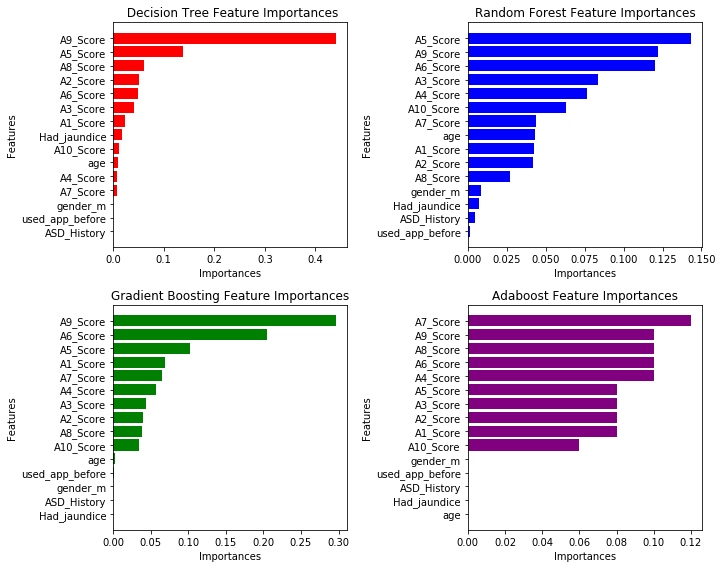

In [52]:
# Plot feature importances
model_list_p = [ gs_dt_p,gs_rf_classifier_p, gs_gb_p, gs_adb_p]
plot_feature_importance(model_list_p)

In [53]:
#save final model
with open('ASD_Adult_model.pkl', 'wb') as final_model:
    pkl.dump(gs_adb.best_estimator_, final_model)

**Summary**

Autism dataset consisting of 709 rows and 19 columns were explored and a model that predicts whether an adult will be diagonised with autism disorder was built from features comprising of set of behavioural questions about the 
 participants (A1-A10) and some personal information. Correlation plot of the features with the target revealed that A1-A10 features more strongly correlated with the features and could be better predictors. 
A model that predicts the majority class was chosen as the baseline and different models were tested including Naive Bayes, Decision tree, Random forest, Gradient boosting and Adaboost. The f1 score was chosen as a metric to measure the performance of the models and it was found that Adaboost has the the highest f1 score and was chosen as the best model. An improvement of 26% on the baseline model was observed. The f1 score was chosen as a metric to measure the performance of the models and it was found that Adaboost has the the highest f1 score and was chosen as the best model. Plots of feature importances show that A5, A7 or A9 has the strongest predictive power depending on the model.

<img src="A.png">